# Домашнее задание 1: Вычисление mel-спектрограммы

In [1]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def hz_to_mel(freq):
    return 2595 * np.log10(1 + freq / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

#### Читаем аудио, задаём параметры

In [3]:
# аудио: "раз два три"
audio, f_s = sf.read('audio_2025-10-30_01-25-54.ogg')

print(f"{f_s=}")
print(f"{audio.shape=}")
print(f"{f_s=}")


f_s=48000
audio.shape=(280320,)
f_s=48000


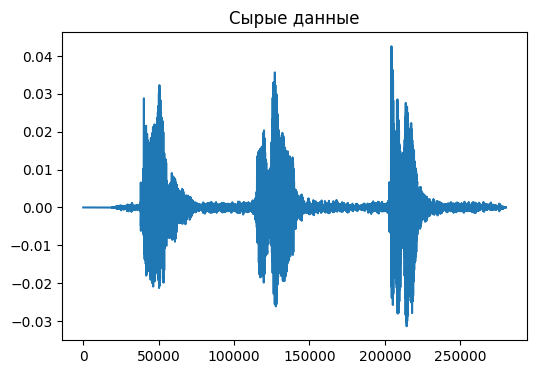

In [4]:
plt.figure(figsize=(6, 4))
plt.title("Сырые данные")
plt.plot(audio)
plt.show()

In [5]:
frame_length = 2048
step_length = 512

M = 40
f_min = 20
f_max = f_s // 2
eps = 1e-10

#### Применяем окно Ханна, считаем fft, мощность

In [6]:
window = np.arange(frame_length)
window = 0.5 * (1 - np.cos(2 * np.pi * window / (frame_length - 1)))

frames_power = []

for frame_start in range(0, len(audio) - frame_length, step_length):
    frame_end = frame_start + frame_length
    frame_after_window = audio[frame_start:frame_end] * window
    fft_result = np.fft.fft(frame_after_window)
    fft_result = fft_result[:frame_length // 2 + 1]
    fft_abs = np.abs(fft_result) ** 2 / frame_length
    frames_power.append(fft_abs)

P = np.array(frames_power).T

#### Строим матрицу фильтробанка

In [7]:
mel_min = hz_to_mel(f_min)
mel_max = hz_to_mel(f_max)

mel_points = np.linspace(mel_min, mel_max, M + 2)

hz_points = mel_to_hz(mel_points)

bin_points = np.floor((frame_length + 1) * hz_points / f_s).astype(int)

H = np.zeros((M, frame_length // 2 + 1))

for i in range(M):
    left = bin_points[i]
    center = bin_points[i + 1]
    right = bin_points[i + 2]

    if left < center:
        H[i, left:center] = np.linspace(0, 1, center - left)

    if center < right:
        H[i, center:right] = np.linspace(1, 0, right - center)

sr = 44100
n_fft = 2048

print(f"{H.shape}")

(40, 1025)


#### Применяем mel-фильтры

In [9]:
S_mel = np.dot(H, P)
S_mel = np.log(S_mel + eps)
S_mel.shape

(40, 544)

#### Визуализируем спектрограмму

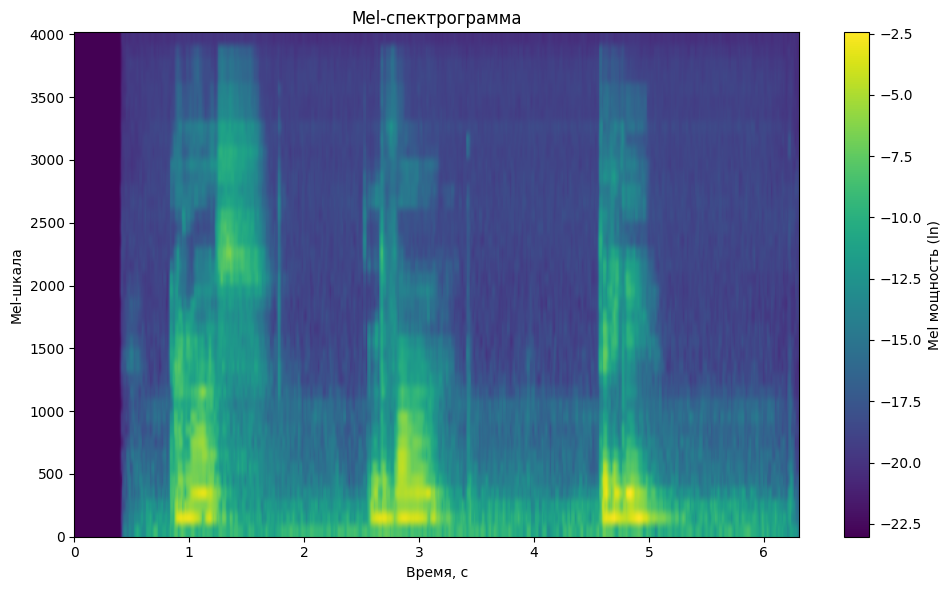

In [10]:
time = np.arange(S_mel.shape[1]) * step_length / sr

plt.figure(figsize=(10, 6))
plt.imshow(S_mel, aspect='auto', origin='lower',
           extent=[time[0], time[-1], 0, mel_points[-1]],
           cmap='viridis')
plt.colorbar(label="Mel мощность (ln)")
plt.title("Mel-спектрограмма")
plt.xlabel("Время, с")
plt.ylabel("Mel-шкала")
plt.tight_layout()
plt.show()

P.S. В начале всё однотонное, так как сигнал там правда нулевой согласно аудио